In [3]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

Using TensorFlow backend.


In [4]:
# set default dimentions for the images
img_width, img_height = 224, 224

#create bottleneck file is conver all the img pixels into numpy array
top_model_weights_path = 'bottleneck_fc_model.h5'


In [5]:
#loading datasets
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

In [6]:
# number of epoch to train top model
epoch = 7 #this has been changed after multiple model run


#batch size used by flow_from_directory and predict_generator
batch_size = 5

In [7]:

#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

In [8]:

#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 4027 images belonging to 5 classes.
Time:  0:30:12.160282


In [9]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [10]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 866 images belonging to 5 classes.
Time:  0:06:29.752743


In [11]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [12]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1464 images belonging to 5 classes.
Time:  0:11:02.561833


# LOAD TRAINING, VALIDATION and TESTING data

In [13]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 4027 images belonging to 5 classes.


In [14]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 866 images belonging to 5 classes.


In [15]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1464 images belonging to 5 classes.


# Training of model

In [16]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



C:\Users\LENOVO\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4027 samples, validate on 866 samples
Epoch 1/7
4027/4027 [==============================] - 26s 7ms/step - loss: 1.1281 - acc: 0.5756 - val_loss: 0.5994 - val_acc: 0.7910
Epoch 2/7
4027/4027 [==============================] - 18s 5ms/step - loss: 0.7727 - acc: 0.7388 - val_loss: 0.4908 - val_acc: 0.8233
Epoch 3/7
4027/4027 [==============================] - 19s 5ms/step - loss: 0.6360 - acc: 0.7810 - val_loss: 0.4350 - val_acc: 0.8522
Epoch 4/7
4027/4027 [==============================] - 23s 6ms/step - loss: 0.5480 - acc: 0.8120 - val_loss: 0.3382 - val_acc: 0.8903
Epoch 5/7
4027/4027 [==============================] - 19s 5ms/step - loss: 0.4645 - acc: 0.8401 - val_loss: 0.2911 - val_acc: 0.9018
Epoch 6/7
4027/4027 [==============================] - 18s 5ms/step - loss: 0.4214 - acc: 0.8532 - val_loss: 0.3079 - val_acc: 0.8891
Epoch 7/7
866/866 [==============================] - 0s

In [17]:
#Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2508900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
Total params: 2,514,205
Trainable params: 2,514,205
Non-trainable params: 0
_________________________________________________________________


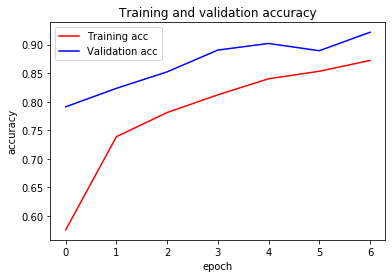

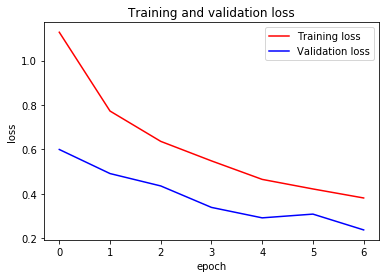

In [18]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [19]:
model.evaluate(test_data, test_labels)

1464/1464 [==============================] - 1s 374us/step


[0.2890122901709353, 0.9016393442622951]

In [20]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.00000000e+00 0.00000000e+00 6.02312207e-01 ... 1.96461514e-01
    9.94315326e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 7.62413070e-02 ... 0.00000000e+00
    1.12581837e+00 0.00000000e+00]
   [1.58983786e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.10688949e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 5.35643585e-02 ... 0.00000000e+00
    9.82706130e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.95575351e-01 ... 0.00000000e+00
    1.45355356e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 5.59204340e-01 ... 0.00000000e+00
    1.36669838e+00 0.00000000e+00]]

  [[2.92393982e-01 0.00000000e+00 3.09342712e-01 ... 4.28359032e-01
    7.17160523e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 6.84435293e-02 ... 1.14029959e-01
    1.09386301e+00 0.00000000e+00]
   [7.66547740e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    9.84859943e-01 0.00000000e+00]
   ...
   [9.29225460e-02 0.00000000e+00 3.15879732e-0

rounded test_labels [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [21]:
flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=flowers )
print(classification_metrics)

              precision    recall  f1-score   support

       daisy       0.97      0.83      0.90       276
   dandelion       0.94      0.90      0.92       330
        rose       0.89      0.88      0.89       280
   sunflower       0.96      0.89      0.92       265
       tulip       0.86      0.93      0.89       313

   micro avg       0.92      0.89      0.90      1464
   macro avg       0.93      0.89      0.90      1464
weighted avg       0.92      0.89      0.90      1464
 samples avg       0.89      0.89      0.89      1464



C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# confution matrix

In [22]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [23]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [24]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


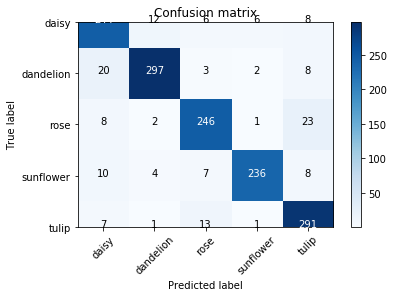

In [25]:
plot_confusion_matrix(confusion_matrix, ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])

Normalized confusion matrix


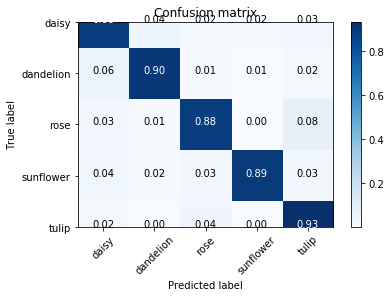

In [26]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'],
                     normalize=True)

# Testing images on model

In [27]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [28]:
def test_single_image(path):
    flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict_proba(bt_prediction)
    for idx, flower, x in zip(range(0,6), flowers , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, flower, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [29]:
path = 'data/test/dog.jpg'

[INFO] loading and preprocessing image...
ID: 0, Label: daisy 3.64%
ID: 1, Label: dandelion 3.14%
ID: 2, Label: rose 89.91%
ID: 3, Label: sunflower 1.52%
ID: 4, Label: tulip 1.79%
Final Decision:
.
..
...
ID: 2, Label: rose


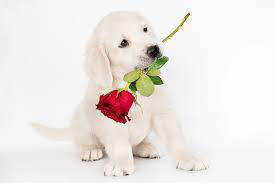

In [30]:
test_single_image(path)